In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [1]:
import sys
sys.path.append('../../')

In [2]:
from codes.docs.analysis import data_preprocessing, logging_outputs

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
import scipy.io
import glob
from collections import defaultdict
%matplotlib inline

# 1. Data Preprocessing and Importing

### Importing volumetric and diffusion dataset

In [4]:
#Volumetric dataset
full_dataset=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='allSubjectsWithKANA_AALVolumes').drop('ID',axis=1)
full_dataset=full_dataset.rename({'Subject':'ID'},axis=1)
full_dataset.rename(columns={'GA at birth':'GA','PMA at birth':'PMA'},inplace=True)
full_dataset=full_dataset.sort_values(by='Session',ascending=False)
full_dataset=full_dataset.drop_duplicates(subset='ID',keep='last')
full_dataset=full_dataset.reset_index(drop=True)

In [5]:
print('volumetric dataset')
full_dataset.shape

volumetric dataset


(675, 201)

In [6]:
ROIs_combinations=data_preprocessing.ROIs_combinations('./dataset/Regions_of_interests.csv')

In [7]:
#Diffusion dataset
diffusion_full_dataset=scipy.io.loadmat('./dataset/diff_dataset/2020_04_MASTER_connectomes90_433subj_SCandFC_TermScansVolOK.mat')
diffusion_matrices=diffusion_full_dataset['SCmu']#use the Structural Connectivity (SIFT2-weighted * Mu) [equivalent to raw connectivity, see SIFT2 paper]
diffusion_matrices=[diffusion_matrices[:,:,i] for i in range(diffusion_matrices.shape[2])] # rearranged them into (433,90,90)
diffusion_matrices=np.asarray(diffusion_matrices)

In [8]:
diffusion_matrices=np.asarray([data_preprocessing.lower_triangle(diffusion_matrices[i]) for i in range(diffusion_matrices.shape[0])])
diffusion_matrices=pd.DataFrame(diffusion_matrices)

In [9]:
diffusion_matrices.columns=data_preprocessing.lower_triangle(ROIs_combinations)

In [10]:
diffusion_subject_id=diffusion_full_dataset['sub'].reshape(-1,1)
diffusion_subject_id=[i[0][0].replace('sub-','') for i in diffusion_subject_id]
diffusion_subject_sess=diffusion_full_dataset['ses'].reshape(-1,1)
diffusion_subject_sess=[i[0][0].replace('ses-','') for i in diffusion_subject_sess]
diffusion_subject_pma=diffusion_full_dataset['pma'].reshape(-1)
diffusion_subject_ga=diffusion_full_dataset['ga'].reshape(-1)
#1 Male/ 2 Female
diffusion_subject_gender=diffusion_full_dataset['sex'].reshape(-1)
diffusion_dataset=pd.DataFrame({'ID':diffusion_subject_id,
'Session':diffusion_subject_sess,'Gender':diffusion_subject_gender,
'GA':diffusion_subject_ga,'PMA':diffusion_subject_pma})
#match the ID to the diffusion matrices
diffusion_dataset=pd.concat((diffusion_dataset,diffusion_matrices),axis=1)
#rearrange by the session, drop the duplicates and keep the last session
diffusion_dataset=diffusion_dataset.sort_values(by='Session',ascending=False)
diffusion_dataset=diffusion_dataset.drop_duplicates(subset='ID',keep='last')
diffusion_dataset=diffusion_dataset.reset_index(drop=True)


In [11]:
print('diffusion dataset')
diffusion_dataset.shape

diffusion dataset


(432, 4010)

In [12]:
Imperial_label=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='IMPERIAL ROIs LEGEND',header=None).drop([0,1],axis=1)
AAL_label=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='AAL LEGEND',header=None).drop(0,axis=1)

In [13]:
from string import digits
AAL_label=np.asarray([str.split(i,' ')[1] for i in np.asarray(AAL_label).reshape(-1)])
Imperial_label=np.asarray([str.strip(i.translate({ord(c): None for c in digits})) for i in (np.asarray(Imperial_label)).reshape(-1)])

### importing microstructure dataset

In [14]:
#microstructure dataset
microstructure_file_path = './dataset/microstructure/052021/'
dHCP_microstructure_info=pd.read_excel(microstructure_file_path + 'dHCP-info-for-H_outcomes_and_rad_scores_05_2021.xlsx')
dHCP_microstructure_info=dHCP_microstructure_info[['ID','potential registration artefacts','GA at birth', 'GA at scan ','Birth weight', 'Head circumference at scan','dmri', 't2ms']]
dHCP_microstructure_info.columns=['ID','potential registration artefacts','GA_micro','PMA_micro','Birth weight', 'Head circumference at scan','dmri', 't2ms']

not_usable_subj_micro=dHCP_microstructure_info[(dHCP_microstructure_info['dmri']!='OK') | (dHCP_microstructure_info['t2ms']!='OK' )| (dHCP_microstructure_info['potential registration artefacts'].notna())] #removed anything that has not OK dmri or t2ms or potential registration artefacts

dHCP_microstructure_info = dHCP_microstructure_info.drop(index=not_usable_subj_micro.index).reset_index(drop=True).drop(labels=['potential registration artefacts','dmri','t2ms'],axis=1)

In [15]:
# Importing the microstructure files
micro_dict_df = defaultdict(pd.DataFrame)
for file in glob.glob(microstructure_file_path+'/*-wm-*-stats*.csv'):
    micro = str.split(file,'-')[-3]
    micro_dict_df[micro] = pd.read_csv(file).dropna(how='any',axis=1)
    micro_dict_df[micro].columns = [i+ str.upper('_'+micro) if i != 'id' else 'ID' for i in micro_dict_df[micro].columns] # adding the microstructure name to each of the feature
    micro_dict_df[micro]['ID'] = [i.split('-')[2].split('_')[0] for i in micro_dict_df[micro]['ID']]# change the ID format

# Adding the microstructure files together into one table.
from functools import reduce
dHCP_microstructure = reduce(lambda left, right: pd.merge(left,right, on='ID',how='outer'), [micro_dict_df['fa'],micro_dict_df['md'],micro_dict_df['t12'],micro_dict_df['t2'],micro_dict_df['fiso']])
#merge the information with the available data

dHCP_microstructure_info = dHCP_microstructure.merge(dHCP_microstructure_info,on='ID',how='right')

In [16]:
print('microstructure info')
dHCP_microstructure_info.shape

microstructure info


(209, 275)

### merging all data with PRS scores

In [17]:
#Reading necessary tables
# schizophrenia_high_scores_european=data_preprocessing.read_table_from_txt('./dataset/SCZ2_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',add_EP=False)# this is the old SCZ file
schizophrenia_high_scores_european=data_preprocessing.read_table_from_txt('./dataset/SCZ3_lifted37_dHCP_merged_cleaned_EUROPEANS_updated.gwas.all.score',add_EP=False)# this is the updated SCZ file 
schizophrenia_high_scores_european_and_asian=data_preprocessing.read_table_from_txt('./dataset/SCZ3_lifted37_dHCP_merged_cleaned_EUROPEANS_ASIAN_361.gwas.all.score',add_EP=False)# this is the SCZ file with asian and europeans
ancestral_PCA_european=data_preprocessing.read_table_from_txt('./dataset/file3_only_europ_10pcs_pca.eigenvec',add_EP=False)
ancestral_PCA_european_and_asian=data_preprocessing.read_table_from_txt('./dataset/euro_asian_361_file3_pca.eigenvec',add_EP=False)

#european_ID and asian_ID
european_ID=list(schizophrenia_high_scores_european['ID'])
asian_ID=[i for i in list(schizophrenia_high_scores_european_and_asian['ID']) if i not in european_ID]

In [18]:
ancestral_PCA_european.columns=['ID']+['euro_Anc_'+i for i in ancestral_PCA_european.columns if 'PC' in i]
ancestral_PCA_european_and_asian.columns=['ID']+['mixed_Anc_'+i for i in ancestral_PCA_european_and_asian.columns if 'PC' in i]

schizophrenia_high_scores_european.columns=['ID']+['PRS_'+i for i in schizophrenia_high_scores_european.columns if i != 'ID']
schizophrenia_high_scores_european_and_asian.columns=['ID']+['PRS_'+i for i in schizophrenia_high_scores_european_and_asian.columns if i != 'ID']

In [19]:
#Merge the diffusion with structural data together
full_dataset=full_dataset.merge(diffusion_dataset,on='ID',suffixes=('_vol','_diff'),how='outer')#merging the diffusion dataset
full_dataset = full_dataset.merge(dHCP_microstructure_info,on='ID',how='outer')# merging the microstructure dataset

ancestry_PCA_combined = ancestral_PCA_european.merge(ancestral_PCA_european_and_asian,on='ID',how='outer')
full_dataset=full_dataset.merge(ancestry_PCA_combined,on='ID',how='outer').merge(schizophrenia_high_scores_european_and_asian,on='ID',how='outer')

full_dataset['cohort']=['european' if i in european_ID else 'asian' if i in asian_ID else 'other' for i in full_dataset['ID']]

In [20]:
full_dataset['termness'] = ['term' if (ga_struc >=37) | (ga_micro >=37) else 'preterm/term_at_scan' if ((ga_struc < 37) & (pma_struc>=37)) | ((ga_micro < 37) & (pma_micro>=37)) else 'preterm' if (ga_struc < 37) | (ga_micro < 37) else 'not available' for (ga_struc,pma_struc,ga_micro,pma_micro) in np.asarray(full_dataset[['GA_vol','PMA_vol','GA_micro','PMA_micro']])]

### saving full dataset

In [21]:
pd.pivot_table(full_dataset,values=['GA_vol','PMA_vol'],index=['cohort','termness'],aggfunc={'cohort':np.count_nonzero,
                                                                                   'GA_vol':np.mean,
                                                                                   'PMA_vol':np.mean})

GA_vol    PMA_vol  cohort
cohort   termness                                          
asian    not available               NaN        NaN       5
         preterm               31.897959  33.816327       7
         preterm/term_at_scan  35.904762  38.380952       3
         term                  40.007792  41.171429      55
european not available               NaN        NaN      17
         preterm               32.876190  34.495238      17
         preterm/term_at_scan  31.754286  36.911429      50
         term                  40.079132  41.549020     207
other    preterm               31.967419  34.411028      57
         preterm/term_at_scan  32.033333  40.614286      30
         term                  39.891451  41.008436     254

In [22]:
# with open('./dataset/SCZ_asian_ID.txt', 'a') as f:
#     for i in asian_ID:
#         f.writelines(i+'\n')

In [23]:
full_dataset.drop(columns=['Session_vol','Session_diff'],inplace=True)
full_dataset = data_preprocessing.move_multiple_columns(full_dataset,cols_to_move=['Gender','GA_diff','PMA_diff'],ref_col='ID',place='After')

In [24]:
# full_dataset.to_csv('./preprocessed_data/full_preprocessed_dataset.csv',index=False)

In [25]:
european_full_dataset = full_dataset[full_dataset['cohort']=='european']
mixed_full_dataset = full_dataset[full_dataset['cohort']!='other']

### Removing outliers

Outlier is defined using the Anc PCs. Should I do the this for each dataset or all of them together? Note that the ancestry components for european cohort alone is different from ancestry PCs for european from european and asian cohort mixed

In [26]:
european_diffusion_term_dataset = european_full_dataset[(european_full_dataset['termness'] == 'term') & (~european_full_dataset[['GA_diff','euro_Anc_PC1']].isna().any(axis=1))]

european_volumetric_term_dataset = european_full_dataset[(european_full_dataset['termness'] == 'term') & (~european_full_dataset[['GA_vol','euro_Anc_PC1']].isna().any(axis=1))]

european_microstructure_term_dataset = european_full_dataset[(european_full_dataset['termness'] == 'term') & (~european_full_dataset[['GA_micro','euro_Anc_PC1']].isna().any(axis=1))]

mixed_diffusion_term_dataset = mixed_full_dataset[(mixed_full_dataset['termness'] == 'term') & (~mixed_full_dataset[['GA_diff','mixed_Anc_PC1']].isna().any(axis=1))]

mixed_volumetric_term_dataset = mixed_full_dataset[(mixed_full_dataset['termness'] == 'term') & (~mixed_full_dataset[['GA_vol','mixed_Anc_PC1']].isna().any(axis=1))]

mixed_microstructure_term_dataset = mixed_full_dataset[(mixed_full_dataset['termness'] == 'term') & (~mixed_full_dataset[['GA_micro','mixed_Anc_PC1']].isna().any(axis=1))]

In [27]:
print('available number of subjects in each dataset before removing outliers')
pd.DataFrame({'Dataset':['Vol','Diff','Micro'],
             'euro_number':[european_volumetric_term_dataset.shape[0],european_diffusion_term_dataset.shape[0],european_microstructure_term_dataset.shape[0]],
              'mixed_number':[mixed_volumetric_term_dataset.shape[0],mixed_diffusion_term_dataset.shape[0],mixed_microstructure_term_dataset.shape[0]]})

available number of subjects in each dataset before removing outliers


,Dataset,euro_number,mixed_number
0,Vol,204,259
1,Diff,155,191
2,Micro,153,153


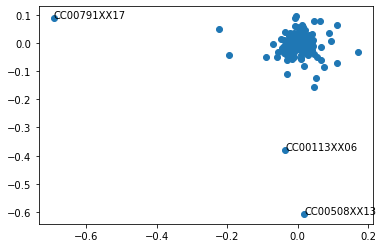

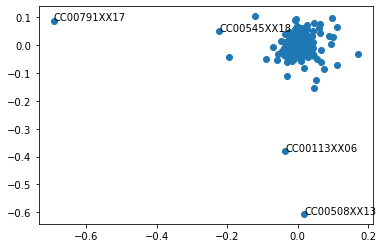

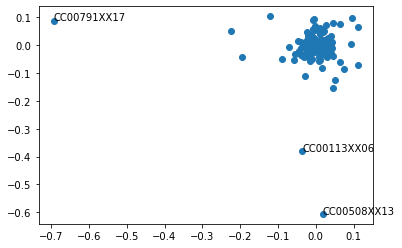

In [28]:
from scipy import stats

def remove_outliers(df,cohort='euro_',ancestry=['Anc_PC2','Anc_PC3']):
    new_df = df.copy()
    outliers = new_df.index[(np.abs(new_df[cohort+ancestry[0]].agg(stats.zscore))>=3.5)|(np.abs(new_df[cohort+ancestry[1]].agg(stats.zscore))>=3.5)]
    
    fig,ax= plt.subplots()
    ax.scatter(new_df.loc[:,cohort+ancestry[0]],new_df.loc[:,cohort+ancestry[1]])
    for i,txt in enumerate(new_df.loc[outliers,'ID']):
        ax.annotate(txt,(new_df.loc[outliers[i],cohort+ancestry[0]],new_df.loc[outliers[i],cohort+ancestry[1]]))
    return new_df.drop(index=outliers),outliers

# #removing outliers using the ancestrial PCA
european_diffusion_term_dataset,_ = remove_outliers(european_diffusion_term_dataset)
european_volumetric_term_dataset,_ = remove_outliers(european_volumetric_term_dataset)
european_microstructure_term_dataset,_ = remove_outliers(european_microstructure_term_dataset)


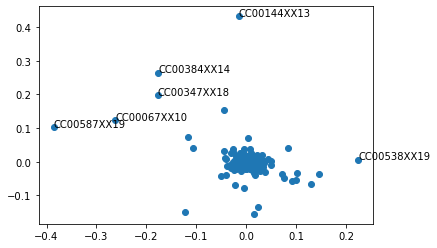

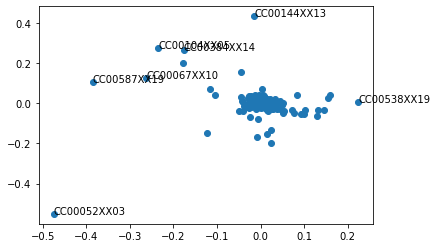

In [29]:
mixed_diffusion_term_dataset,_=remove_outliers(mixed_diffusion_term_dataset,'mixed_',['Anc_PC4','Anc_PC5'])
mixed_volumetric_term_dataset,_=remove_outliers(mixed_volumetric_term_dataset,'mixed_',['Anc_PC4','Anc_PC5'])

### saving preprocessed data without outliers

In [36]:
european_diffusion_term_dataset.to_csv('./preprocessed_data/diffusion/term/european_diffusion_term_dataset.csv',index=False)
european_volumetric_term_dataset.to_csv('./preprocessed_data/volumetric/term/european_volumetric_term_dataset.csv',index=False)
european_microstructure_term_dataset.to_csv('./preprocessed_data/microstructure/term/european_microstructure_term_dataset.csv',index=False)


mixed_diffusion_term_dataset.to_csv('./preprocessed_data/diffusion/term/mixed_diffusion_term_dataset.csv',index=False)
mixed_volumetric_term_dataset.to_csv('./preprocessed_data/volumetric/term/mixed_volumetric_term_dataset.csv',index=False)

# IGNORE

## 1.3 Adjusting for covariates (Volumetric)

Text(0, 0.5, 'PC3')

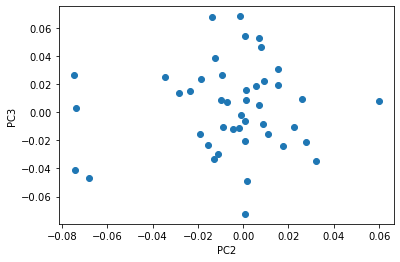

In [90]:
plt.scatter(european_ancestral_PCA[:,1],european_ancestral_PCA[:,2])
plt.xlabel('PC2')
plt.ylabel('PC3')
#check the PC1 vs. PC2, PC2 vs PC3, etc. until I see a structureless blob.

For PRS: I adjusted for the first 3 ancestral PCs.

For volumetric data: I adjusted for age at scan, at birth, intracranial volume, and total volume.

In [91]:
#adjusting for covariates:
#for PRS: I adjusted for 3 PCs. and for connectivity and structural data: I adjusted for age at scan, at birth, intracranial volume (not for connectivity) and gender. similar to Harriet's paper and Shi et al., 2012 (although this one has number of fibers regressed out as well).

adjusted_european_PRS_schizophrenia=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_PRS_schizophrenia,european_ancestral_PCA[:,0:3])#adjust for the first 3 PCs.
adjusted_european_PRS_schizophrenia=adjusted_european_PRS_schizophrenia.astype('float64')

adjusted_european_volumetric_AAL_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_volumetric_AAL_matrix,european_age_at_scan,european_gestational_age,european_icv,european_total_volume)
adjusted_european_volumetric_AAL_matrix=adjusted_european_volumetric_AAL_matrix.astype('float64')

adjusted_european_volumetric_Imperial_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_volumetric_Imperial_matrix,european_age_at_scan,european_gestational_age,european_icv,european_total_volume)
adjusted_european_volumetric_Imperial_matrix=adjusted_european_volumetric_Imperial_matrix.astype('float64')

#remove the CSF, Extracranial and Intracranial volume from adjusted_european_volumetric_Imperial_matrix
adjusted_european_volumetric_Imperial_matrix=np.delete(adjusted_european_volumetric_Imperial_matrix,[82,83,84],axis=1)
Imperial_label=np.delete(Imperial_label,[82,83,84],axis=0)

#remove the WM from adjusted_european_structural_schizophrenia
adjusted_european_GM_volumetric_Imperial_matrix=np.delete(adjusted_european_volumetric_Imperial_matrix,[idx for idx,i in enumerate(Imperial_label) if 'WM' in i or 'Corpus' in i],axis=1)
Imperial_GM_labels=np.delete(Imperial_label,[idx for idx,i in enumerate(Imperial_label) if 'WM' in i or 'Corpus' in i],axis=0)

## 1.3.1 Adjusting covariates (Diffusion)

Text(0, 0.5, 'PC3')

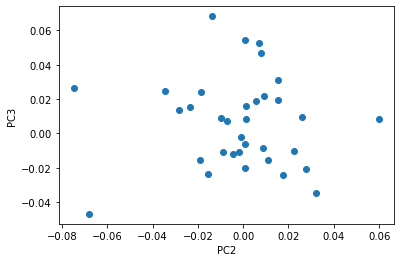

In [33]:
plt.scatter(european_diffusion_ancestral_PCA[:,1],european_diffusion_ancestral_PCA[:,2])
plt.xlabel('PC2')
plt.ylabel('PC3')
#check the PC1 vs. PC2, PC2 vs PC3, etc. until I see a structureless blob.

In [34]:
#adjusting for covariates:
#for PRS: I adjusted for 3 PCs. and for connectivity and structural data: I adjusted for age at scan, at birth, intracranial volume (not for connectivity) and gender. similar to Harriet's paper and Shi et al., 2012 (although this one has number of fibers regressed out as well).

adjusted_european_diffusion_PRS_schizophrenia=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_diffusion_PRS_schizophrenia,european_diffusion_ancestral_PCA[:,0:3])#adjust for the first 3 PCs.
adjusted_european_diffusion_PRS_schizophrenia=adjusted_european_diffusion_PRS_schizophrenia.astype('float64')

adjusted_european_diffusion_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_diffusion_matrix,european_diffusion_age_at_scan,european_diffusion_gestational_age,european_diffusion_gender)
adjusted_european_diffusion_matrix=adjusted_european_diffusion_matrix.astype('float64')

## 1.4. Saving the processed data (Volumetric)

In [96]:
def name_of_global_obj(xx):
    return [objname for objname, oid in globals().items()
        if id(oid)==id(xx) and not objname.startswith('_')][0]
def save_to_npy(filepath,*args):
    for i in args:
        temp_name=filepath+name_of_global_obj(i)+'.npy'
        np.save(temp_name,i)

In [22]:
# save_to_npy('./preprocessed_data/preterm/',adjusted_european_PRS_schizophrenia,european_PRS_schizophrenia,adjusted_european_volumetric_AAL_matrix,adjusted_european_volumetric_Imperial_matrix,Imperial_GM_labels,adjusted_european_GM_volumetric_Imperial_matrix, AAL_label,european_age_at_scan,european_gestational_age,european_icv)

In [97]:
save_to_npy('./preprocessed_data/volumetric/preterm/',adjusted_european_PRS_schizophrenia,european_PRS_schizophrenia,adjusted_european_volumetric_AAL_matrix,adjusted_european_volumetric_Imperial_matrix,Imperial_GM_labels,adjusted_european_GM_volumetric_Imperial_matrix, AAL_label,european_age_at_scan,european_gestational_age,european_icv)

In [99]:
! ls preprocessed_data/volumetric/preterm/

AAL_label.npy
Imperial_GM_labels.npy
adjusted_european_GM_volumetric_Imperial_matrix.npy
adjusted_european_PRS_schizophrenia.npy
adjusted_european_volumetric_AAL_matrix.npy
adjusted_european_volumetric_Imperial_matrix.npy
european_PRS_schizophrenia.npy
european_age_at_scan.npy
european_gestational_age.npy
european_icv.npy


## 1.4.1 Saving the processed data (Diffusion)

In [25]:
def name_of_global_obj(xx):
    return [objname for objname, oid in globals().items()
        if id(oid)==id(xx) and not objname.startswith('_')][0]
def save_to_npy(filepath,*args):
    for i in args:
        temp_name=filepath+name_of_global_obj(i)+'.npy'
        np.save(temp_name,i)

In [35]:
save_to_npy('./preprocessed_data/diffusion/preterm/',adjusted_european_diffusion_PRS_schizophrenia,adjusted_european_diffusion_matrix,european_diffusion_PRS_schizophrenia,european_diffusion_matrix,european_diffusion_age_at_scan,european_diffusion_gestational_age,european_diffusion_gender)

array(['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R',
       'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L',
       'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R',
       'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L',
       'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R',
       'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L',
       'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R',
       'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R',
       'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R',
       'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R',
       'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L',
       'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R',
       'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L',
       'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R',
       'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R',
   

In [61]:
# preprocessing the matlab volumetric file from dHCP
matlab_vols=pd.read_excel(open('./dataset/matlab_volumes/Reformatted_data.xlsx','rb'),header=None).drop(0,axis=1)
Imperial_labels=pd.read_excel(open('./dataset/matlab_volumes/all_labels.xlsx','rb'),header=None).drop(0,axis=1)
matlab_vols=matlab_vols[matlab_vols.index!=360]#removed outlier
matlab_vols.columns=['ID','Session','GA_vol','PMA_vol','Gender']+['T1_Imperial '+str(i) for i in range(1,88)]+['T2_Imperial '+str(i) for i in range(1,88)]+['vol_Imperial '+str(i) for i in range(1,88)]
matlab_vols[[i for i in matlab_vols.columns if 'vol_' in i]]=matlab_vols[[i for i in matlab_vols.columns if 'vol_' in i]]*100000# conversion to ml

In [63]:
matlab_vols.to_csv('preprocessed_data/volumetric/Matlab_volumetric_reformatted.csv',index=False)